In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
train_dir = "C:\\Users\\Vignesh T\\Downloads\\catsanddogs\\dataset\\training_set" 
test_dir = "C:\\Users\\Vignesh T\\Downloads\\catsanddogs\\dataset\\test_set"

In [4]:
CFG = {
    'seed': 77,
    'batch_size': 16,
    'img_size': (299, 299),
    'epochs': 5,
    'patience': 5
}

In [5]:
train_data_generator = ImageDataGenerator(
    validation_split=0.15,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=preprocess_input,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.15)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
def create_data_generator(directory, data_generator, subset):
    return data_generator.flow_from_directory(
        directory,
        target_size=CFG['img_size'],
        shuffle=True if subset == 'training' else False,
        seed=CFG['seed'],
        class_mode='categorical',
        batch_size=CFG['batch_size'],
        subset=subset
    )

In [8]:
train_generator = create_data_generator(train_dir, train_data_generator, 'training')
validation_generator = create_data_generator(train_dir, val_data_generator, 'validation')
test_generator = create_data_generator(test_dir, test_data_generator, None)

Found 6800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
num_classes = len(classes)
print('Classes:', classes)

Classes: ['cats', 'dogs']


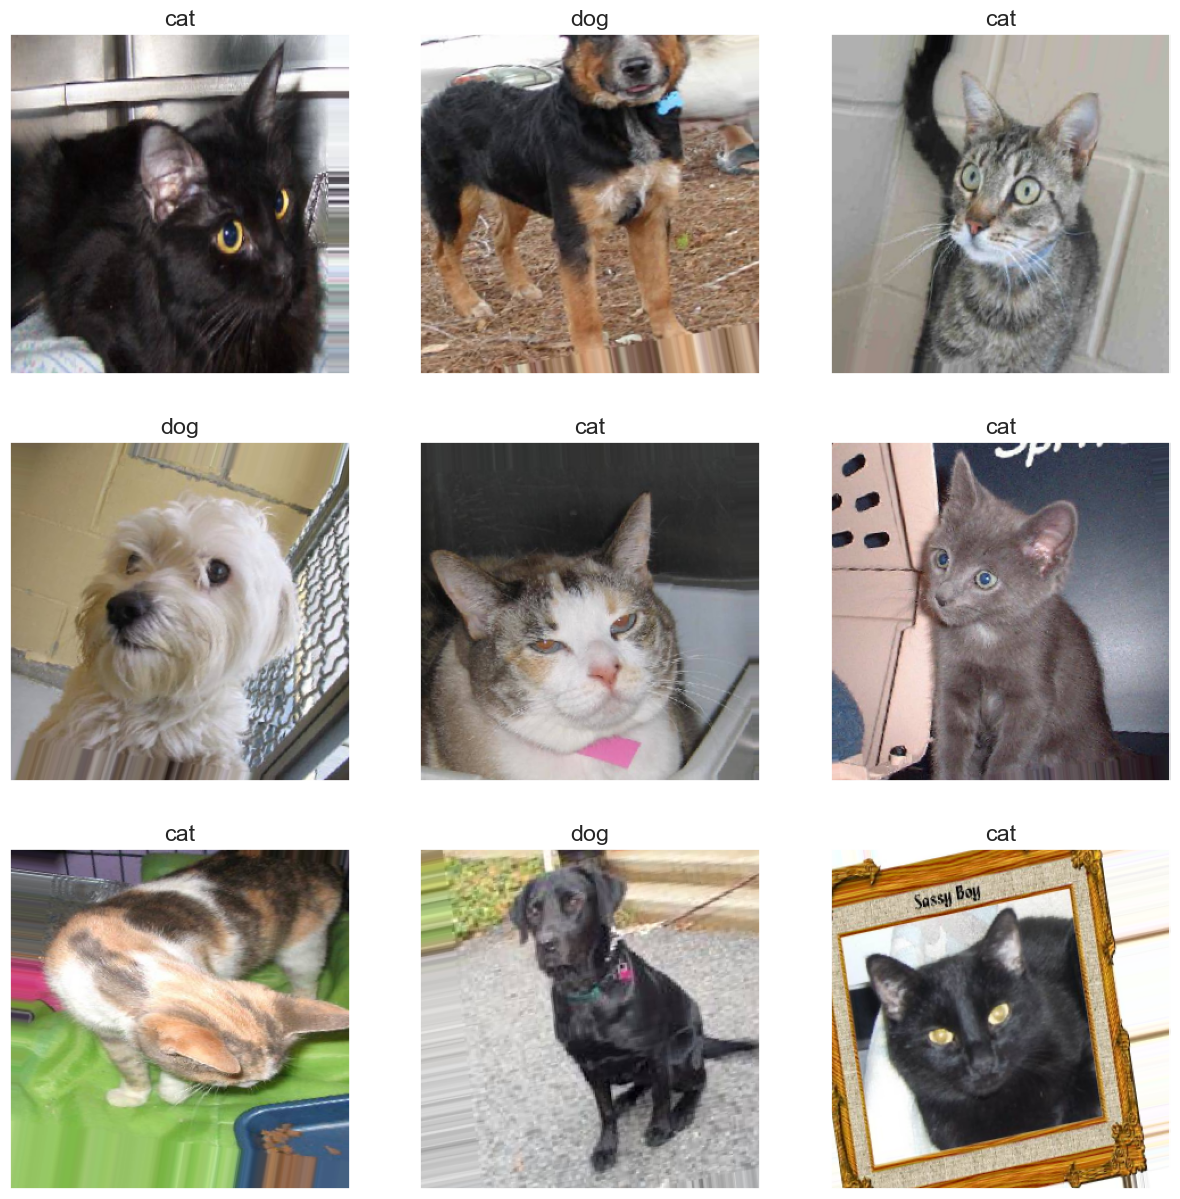

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 15))
for i in range(9):
    batch = next(train_generator)  # Get the next batch of data
    ax = plt.subplot(3, 3, i + 1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    imgs = (batch[0] + 1) * 127.5
    label = batch[1][0]  # Extract the label
    if train_generator.class_mode == 'binary':
        label = int(label)  # For binary classification
    else:
        label = np.argmax(label)  # For categorical classification
    image = imgs[0].astype('uint8')
    plt.imshow(image)
    plt.title('dog' if label == 1 else 'cat')
plt.show()

In [16]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step


In [17]:
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

In [18]:
model = Model(inputs=base_model.input, outputs=predictions)
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [20]:
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Save the best model
save_checkpoint = ModelCheckpoint(filepath='model.keras', monitor='val_loss', save_best_only=True, verbose=1)
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // CFG['batch_size'],
    epochs=CFG['epochs'],
    callbacks=[save_checkpoint, early_stopping],
    validation_data=validation_generator,
    verbose=True,
    validation_steps=nb_validation_samples // CFG['batch_size']
)

Epoch 1/5


C:\Users\Vignesh T\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9676 - loss: 0.2277
Epoch 1: val_loss improved from inf to 0.01696, saving model to model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 1222s 3s/step - accuracy: 0.9677 - loss: 0.2275 - val_accuracy: 0.9942 - val_loss: 0.0170
Epoch 2/5


C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.01696 to 0.00000, saving model to model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9882 - loss: 0.0461
Epoch 3: val_loss did not improve from 0.00000
425/425 ━━━━━━━━━━━━━━━━━━━━ 1124s 3s/step - accuracy: 0.9882 - loss: 0.0460 - val_accuracy: 0.9950 - val_loss: 0.0143
Epoch 4/5

Epoch 4: val_loss did not improve from 0.00000
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9945 - loss: 0.0159
Epoch 5: val_loss did not improve from 0.00000
425/425 ━━━━━━━━━━━━━━━━━━━━ 1134s 3s/step - accuracy: 0.9945 - loss: 0.0159 - val_accuracy: 0.9950 - val_loss: 0.0146


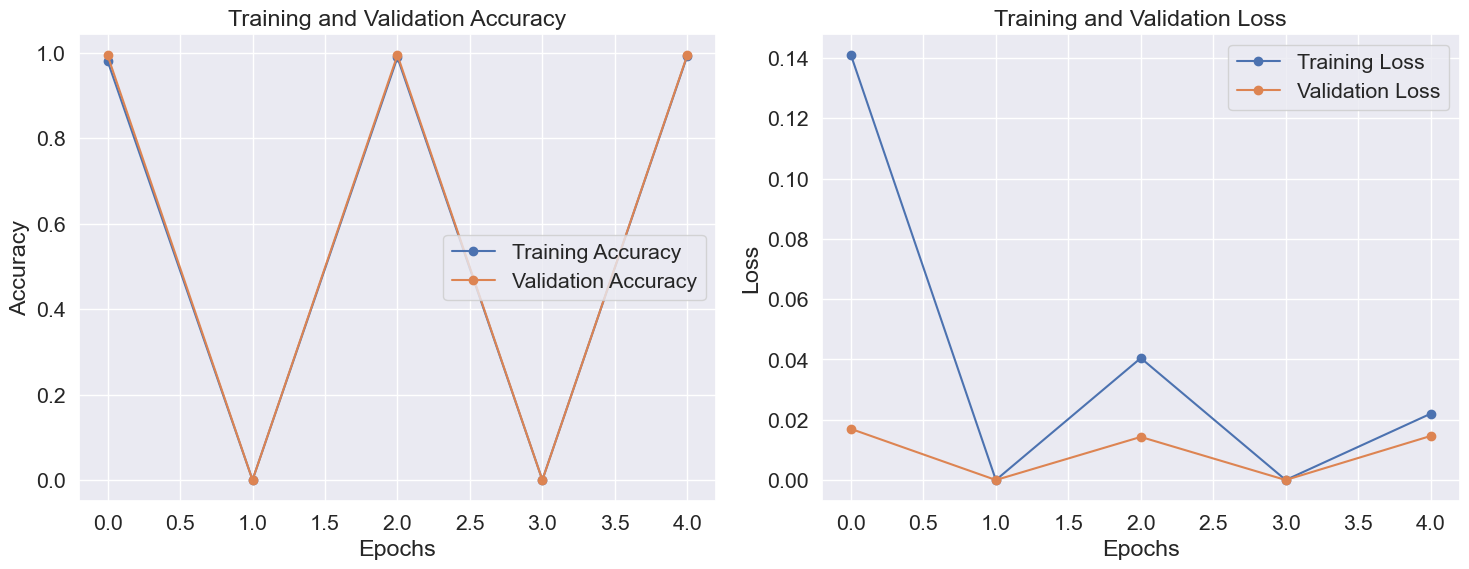

In [22]:
def plot_accuracy_and_loss(history):
    plt.figure(figsize=(15, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history)

125/125 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step


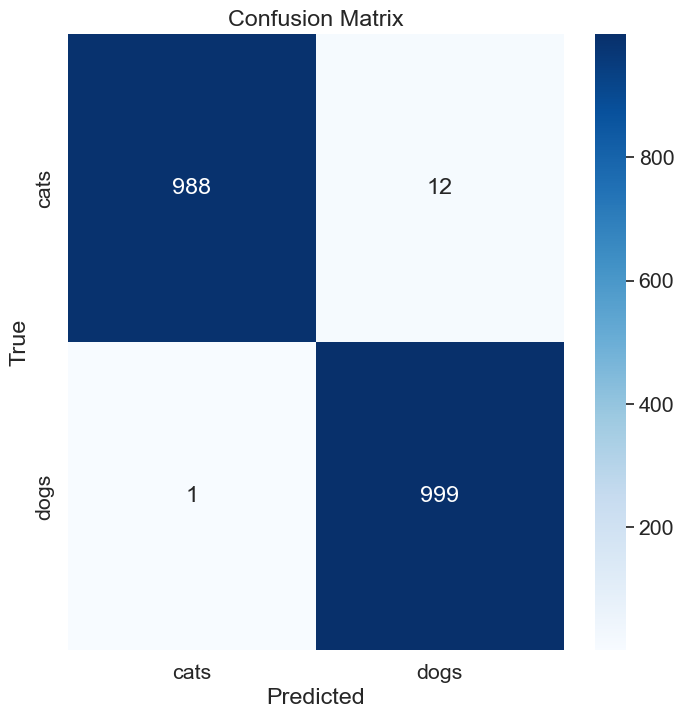

In [23]:
def plot_confusion_matrix(model, test_generator):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(model, test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


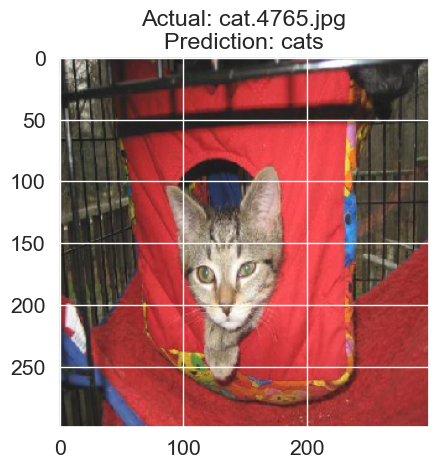

In [24]:
random_image = random.choice(test_generator.filepaths)
img_path = random_image

# Load the random test image
img = keras.preprocessing.image.load_img(img_path, target_size=CFG['img_size'])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = preprocess_input(np.expand_dims(img_array, axis=0))

# Make a prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
predicted_class = classes[predicted_class_index]

# Display the image and prediction
plt.imshow(img)
plt.title(f'Actual: {os.path.basename(img_path)}\nPrediction: {predicted_class}')
plt.show()